In [1]:
# Jackson Cown
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import albumentations as A

import os
from time import sleep

import matplotlib.pyplot as plt
import cv2

from tqdm.notebook import trange, tqdm
from IPython.display import HTML, display

In [2]:
# Change tqdm text color to fit jupyter theme - Might look weird on other IDEs
def set_css_in_cell_output():
    display(HTML('''
        <style>
            .jupyter-widgets {color: #d5d5d5 !important;}
            .widget-label {color: #d5d5d5 !important;}
        </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css_in_cell_output)

### Data Loading

In [3]:
# Setting up our path variables
DATA_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data'
TRAIN_CSV = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/train.csv'
TRAIN_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/train'
TEST_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/test'
MASK_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks'
MASK_COMPILED_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks_compiled'

In [4]:
# Load training data into pandas dataframe
train = pd.read_csv(TRAIN_CSV)
print(f'Training Set Shape: {train.shape} - {train["id"].nunique()} \
Images - Memory Usage: {train.memory_usage().sum() / 1024 ** 2:.2f} MB')
train.head()

Training Set Shape: (73585, 9) - 606 Images - Memory Usage: 5.05 MB


,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


Image ID: 0030fd0e6378


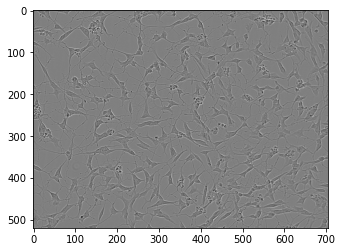

Image ID: 0140b3c8f445


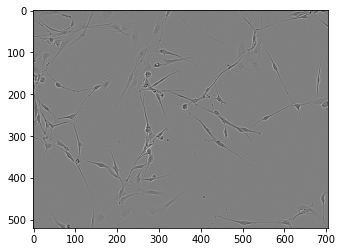

Image ID: 01ae5a43a2ab


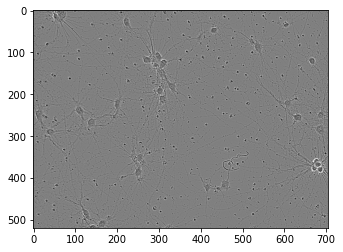

In [5]:
# Image data check helper function
def show_images():
    """Display a number of images to check data"""
    path = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data'
    img_path = os.listdir(f'{path}/train')
    for i in range(3):
        print(f'Image ID: {img_path[i][0:12]}')
        img = cv2.imread(f'{path}/train/{img_path[i]}')
        plt.imshow(img)
        plt.show()


# Check the image data
show_images()

### Run Length Encoding and Decoding
* Annotations in train.csv are rle encoded
* Each instance must be decoded into a cell mask and saved
* Each mask corresponding to a certain image will be compiled into one mask and saved

In [6]:
def decode(rle, shape):
    """
    Takes an Run Length Encoded input and converts it into a numpy array
    rle: reun length encoded string
    shape: tuple of dimensions for the final array
    Returns: a numpy array where 1 corresponds to the annotation and 0 is nothing
    """
    rle_list = rle.split() # List of alternating pixel and RL values
    pixels = rle_list[::2]
    run_lengths = rle_list[1::2]
    # Convert to numpy arrays
    pixels_arr = np.asarray(pixels, dtype=int)
    lengths_np = np.asarray(run_lengths, dtype=int)
    # Calculate start and stop pixels for each rle pair
    pixel_start =  np.subtract(pixels_arr, int(1))
    pixel_stop = pixel_start + lengths_np
    # Create an empty numpy array to fill with mask
    mask = np.zeros(shape[0] * shape[1])
    for start, stop in zip(pixel_start, pixel_stop):
        mask[start:stop] = 255
    return mask.reshape(shape) # Numpy array


def encode(mask):
    """
    mask: the mask to perform run length encoding on
    Returns: a tuple (img_id, annotation)
    """
    raise NotImplementedError("Implement Encoding Function")

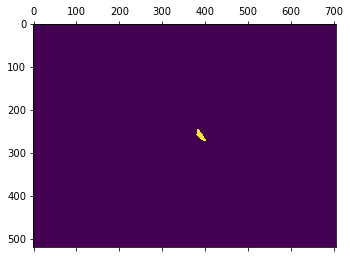

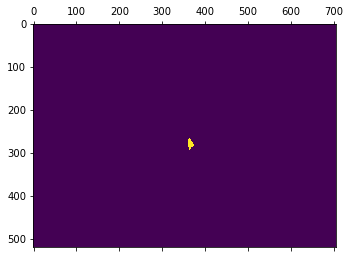

In [7]:
# Testing the rle decoder
X = decode("173567 3 174270 5 174974 5 175678 6 176382 7 177085 9 177789 9 178493 \
            10 179197 11 179901 12 180605 12 181308 14 182012 15 182716 15 183420 \
            16 184125 16 184831 15 185536 14 186241 14 186947 12 187651 13 188356 \
            12 189061 12 189767 10 190472 10 191177 9 191883 7 192589 5 193295 2 194000 1", (520, 704))
plt.matshow(X)
plt.show()
X = decode(train["annotation"][1], (520, 704))
plt.matshow(X)
plt.show()

### Generating the mask data

In [8]:
# Decode and store all annotations
def save_masks(df, shape=(520, 704)):
    """
    Takes the training dataframe, performs rle decoding on each instance,
    and writes each mask to the data directory with cv2.
    df: training dataframe
    shape: the shape of the images; default=(704, 520)
    Used Julia Segmentations but this works now.
    """
    # Create folders for masks
    path = DATA_PATH
    images = os.listdir(f'{path}/train')
    for image in images:
        os.mkdir(f'{path}/masks/{image[0:12]}')
        
    # get img id and annotations
    id_nums = df["id"].tolist()
    annotations = df["annotation"].tolist()
    # Holder vars
    inst_list = []
    count = 0
    # Loop through each annotation
    for i, (img_id, annotation) in enumerate(zip(id_nums, annotations)):
        # Check if new image
        if (img_id not in inst_list):
            count = 0
            inst_list.append(img_id)
        # build mask
        img = decode(annotation, shape)
        # Show some stats sometimes
        if (i % 1000 == 0):
            print(f'Image: {img_id}\nInstance: {count}')
            plt.matshow(img)
            plt.show()
        # Save masks
        cv2.imwrite(f'{path}/masks/{img_id}/{count}.png', img)
        count += 1


# Compile annotations into one mask for each image
def compile_masks(df, shape=(520, 704, 3)):
    """
    Takes the training data frame, and compiles all the saved
    masks corresponding to one training sample into one image.
    Saves the compiled masks and repeats for every image.
    df: training dataframe
    shape: shape of the images to save.
    """
    # Load img IDs
    path = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data'
    images = os.listdir(f'{path}/train') 
    # Loop over each image
    for i, image in enumerate(images):
        # Prepare mask of correct shape
        masks = np.zeros(shape)
        # Loop over each cell instance for this image
        instances = os.listdir(f'{path}/masks/{image[0:12]}')
        for instance in instances:
            masks += cv2.imread(f'{path}/masks/{image[0:12]}/{instance}')
        # Clip the maximum value and save
        masks = np.clip(masks, 0.0, 255.0)
        cv2.imwrite(f'{path}/masks_compiled/{image}', masks)
        # Show every 10th compiled image
        if (i % 10 == 0):
            print(f'Image: {image[0:12]} ({i}/{len(images)})')
            plt.matshow(masks)
            plt.show()

In [9]:
# Uncomment to generate mask images
#save_masks(train)

In [10]:
# Uncomment to generate compiled mask images
#compile_masks(train)

<class 'numpy.ndarray'>
uint8
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]


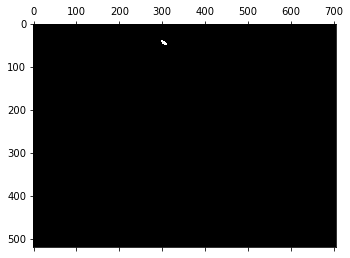

In [11]:
# Checking save_masks()
test_img = cv2.imread('C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks/0f08d640930b/10.png')
print(type(test_img))
print(test_img.dtype) # Currently set up to return 
print(test_img[0])
plt.matshow(test_img)
plt.show()

Mask Count: 606
['0030fd0e6378.png', '0140b3c8f445.png', '01ae5a43a2ab.png', '026b3c2c4b32.png', '029e5b3b89c7.png', '0323e81d23d9.png', '03b27b381a5f.png', '042c17cd9143.png', '042dc0e561a4.png', '04928f0866b0.png', '049f02e0f764.png', '04cd81dfb245.png', '053d61766edb.png', '05c61f0f46b7.png', '061b49d7dbbb.png', '06c5740c8b18.png', '0728b8f39241.png', '07e9ba109e34.png', '083b178bb184.png', '085eb8fec206.png', '08f52aa2add3.png', '097d60b2cf71.png', '0a6ecc5fe78a.png', '0ba181d412da.png', '0c5938ac5e3c.png']


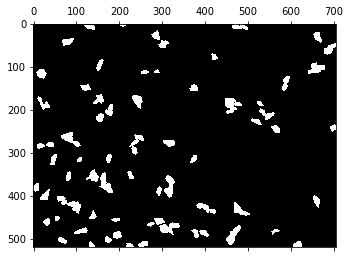

In [12]:
# Checking masks_compile()
mask_files = os.listdir('C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks_compiled')
test_img = cv2.imread('C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data/masks_compiled/0f08d640930b.png')
print(f'Mask Count: {len(mask_files)}')
print(mask_files[0:25])
plt.matshow(test_img)
plt.show()

### Dataset Class

In [13]:
# torch.util.data.Dataset
class CellDataset(Dataset):
    def __init__(self, data=train, train=False, transform=None):
        # Load data
        self.data = data
        # path variables
        self.BASE_PATH = 'C:/Users/cownj/0Python/Sartorius - Cell Instance Segmentation/data' # Change to an init param
        self.mask_paths = os.listdir(f'{self.BASE_PATH}/masks_compiled')
        # Check if train or test and split data
        self.train = train
        self.mask_paths_train, self.mask_paths_test = train_test_split(self.mask_paths, test_size=0.2, random_state=42)
        if self.train == True:
            self.mask_paths = self.mask_paths_train
        else:
            self.mask_paths = self.mask_paths_test
        # Register any transforms
        self.transforms = transform
            
    def __len__(self):
        # num unique images
        return len(self.mask_paths)
    
    def __getitem__(self, index):
        # Load Mask
        mask = cv2.imread(f'{self.BASE_PATH}/masks_compiled/{self.mask_paths[index]}').astype(np.float32)
        # U-Net doesn't understand significance of 255 so just set it to 1.0
        mask[mask == 255.0] = 1.0
        # Load Image
        img = cv2.imread(f'{self.BASE_PATH}/train/{str(self.mask_paths[index])[0:12]}.png')
        # Apply any transforms to Image and Mask; return them with img_id
        if self.transforms:
            transformed = self.transforms(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        else:
            img = img.astype(np.float32)
            mask = mask.astype(np.float32)
        return self.mask_paths[index][0:12], img, mask

Num Instances: 122
Mask Shape: (520, 704, 3):float32
Img Shape: (520, 704, 3):float32

Image ID: 1e7ac54a9422


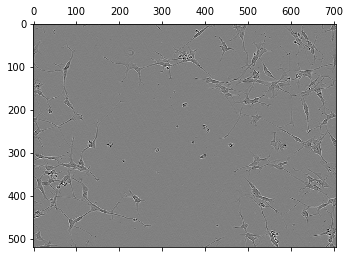

Mask ID: 1e7ac54a9422


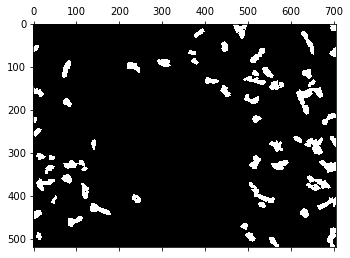

Combined:


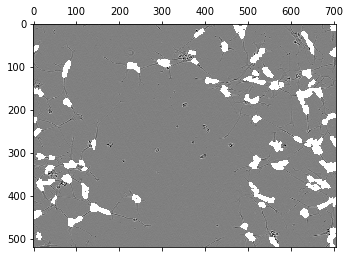

In [14]:
# Testing basic dataset functionality
cell_data = CellDataset(data=train, train=False) # Testing set
print(f'Num Instances: {len(cell_data)}')
img_id, img, mask = cell_data[2]
# Load mask and normalized img
mask = mask.astype(np.float32)
img = (img / 255.0).astype(np.float32)
# Print sample info
print(f'Mask Shape: {mask.shape}:{mask.dtype}\nImg Shape: {img.shape}:{img.dtype}\n')
# Image
print(f'Image ID: {img_id}')
plt.matshow(img)
plt.show()
# Image Mask
print(f'Mask ID: {img_id}')
plt.matshow(mask)
plt.show()
# Image with mask overlaid
print('Combined:')
plt.matshow(np.clip((img + mask), 0, 1.0)) # dtype is int; clip at 255
plt.show()

### Data Augmentations

Image Shape: (512, 512, 3):float32
Mask Shape: (512, 512, 3):float32


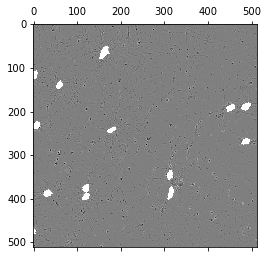

In [15]:
# Building a full list of transforms with Albumentations
transforms = A.Compose([A.Resize(512, 512),
                       A.Normalize(mean=(0.0, 0.0, 0.0),
                                    std=(1.0, 1.0, 1.0),
                                    max_pixel_value=255.0,
                                    p=1.0),
                       A.HorizontalFlip(p=0.5),
                       A.VerticalFlip(p=0.5),
                       A.Rotate(limit=35, p=1.0)])
# Build transformed dataset
cell_data = CellDataset(data=train, train=True, transform=transforms) # Training dataset
# Picking an arbitrary sample
img_id, img, mask = cell_data[2]
print(f'Image Shape: {img.shape}:{img.dtype}\nMask Shape: {mask.shape}:{img.dtype}')
# Albumentations normalizes our img data and type
masked = np.clip((mask + img), 0, 1.0)
plt.matshow(masked)
plt.show()

### DataLoader Class

Num Batches: 121 - Num Instances: 484


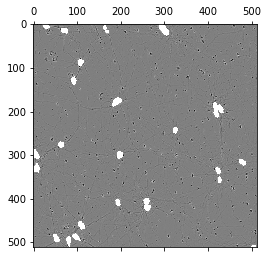

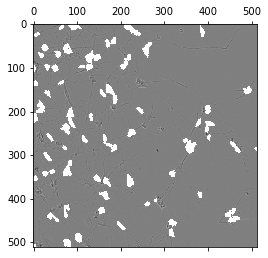

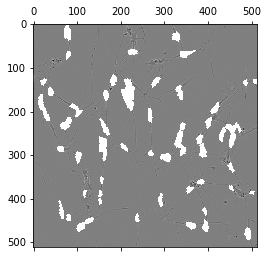

In [16]:
# Create the data loader
cell_dl = DataLoader(cell_data, batch_size=4, drop_last=True, shuffle=True) # testing set
print(f'Num Batches: {len(cell_dl)} - Num Instances: {len(cell_data)}')

# Remember that data loader returns torch tensors because of default_collate(batch)
# Testing the DataLoader
# load 1
test = iter(cell_dl)
img_id, img, mask = test.next()
img = img[0].numpy() # Convert from tensor to ndarray
mask = mask[0].numpy()
masked = np.clip((mask + img), 0, 1)
plt.matshow(masked)
plt.show()

# Load 2
img_id, img, mask = test.next()
img = img[0].numpy()
mask = mask[0].numpy()
masked = np.clip((mask + img), 0, 1)
plt.matshow(masked)
plt.show()

# load 3
img_id, img, mask = test.next()
img = img[0].numpy()
mask = mask[0].numpy()
masked = np.clip((mask + img), 0, 1)
plt.matshow(masked)
plt.show()

# Building a U-Net Model

Main Components:
* Contraction Path
    * Double Convolution
        * 3x3 unpadded
        * ReLU
    * Max Pooling
        * 2x2
        * Stride = 2
        * Downsampling
        * At each downsampling step, double the number of feature channels
* Expansion Path
    * Up - Convolution
        * 2x2
        * Upsampling of feature map
        * Halves the number of feature channels
    * Concatenation
        * With corresponding cropped feature map from contracting path
    * Double Convolution
        * 3x3
        * ReLU
    * Final Convolution
        * 1x1
        * Map each 64 component feature vector to the desired number of classes

* 23 Total Convolutional Layers
    

In [17]:
# Sequential Conv2d with batchnorm and relu after each layer
class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    
    def forward(self, x):
        return self.conv1(x)


# Main Semantic Segmentation Model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        # Contraction Layer
        self.downsampling = nn.ModuleList() # Double Conv List
        self.maxpool = nn.MaxPool2d(2, 2, padding=1)
        self.downsampling.append(DoubleConv2d(in_channels, 64))
        self.downsampling.append(DoubleConv2d(64, 128))
        self.downsampling.append(DoubleConv2d(128, 256))
        self.downsampling.append(DoubleConv2d(256, 512))
        self.downsample_final = DoubleConv2d(512, 1024)
        
        # Expansion Layer
        self.upsampling1 = nn.ModuleList() # ConvTranspose2d
        self.upsampling2 = nn.ModuleList() # Double Conv
        self.upsampling1.append(nn.ConvTranspose2d(1024, 512, 2, 2)) # 512 * 2 because of skip connection
        self.upsampling1.append(nn.ConvTranspose2d(512, 256, 2, 2))
        self.upsampling1.append(nn.ConvTranspose2d(256, 128, 2, 2))
        self.upsampling1.append(nn.ConvTranspose2d(128, 64, 2, 2))
        self.upsampling2.append(DoubleConv2d(1024, 512))
        self.upsampling2.append(DoubleConv2d(512, 256))
        self.upsampling2.append(DoubleConv2d(256, 128))
        self.upsampling2.append(DoubleConv2d(128, 64))
        # Final 1x1 Convolution
        self.conv_final = nn.Conv2d(64, out_channels, 1)
        
    def forward(self, x):
        # Holder for skip connections
        skips = []
        # Contraction Layer
        for layer in self.downsampling:
            x = layer(x)
            skips.append(x)
            x = self.maxpool(x)
        x = self.downsample_final(x)
        
        # Expansion Layer
        skips = skips[::-1]
        x = self.upsampling1[0](x)
        for i, layer in enumerate(self.upsampling1[1::]):
            # Check dimensions for torch.cat - correct as needed
            if x.shape != skips[i].shape:
                x = TF.resize(x, skips[i].shape[2:])
            x = self.upsampling2[i](torch.cat((skips[i], x), dim=1))
            x = layer(x)
        if x.shape != skips[-1].shape:
                x = TF.resize(x, skips[-1].shape[2:])
        x = self.upsampling2[-1](torch.cat((skips[-1], x), dim=1))
        # Final 1x1 conv
        return self.conv_final(x)

### Loss Functions

In [18]:
# Ref: https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch/notebook
def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.contiguous().view(-1) # Added contiguous
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()
    

class IntersectionOverUnion(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        input = torch.sigmoid(input)
        loss = compute_iou(target, input)
        return loss.mean()

### Training and Evaluation

Eval: 0/121 - Progress:   0%|          | 0/122 [00:00<?, ?it/s]

Test Loss: 1.171 - Test Size: 122 samples

Predictions
-----------------------------------------


Image: 3912a0bede5b


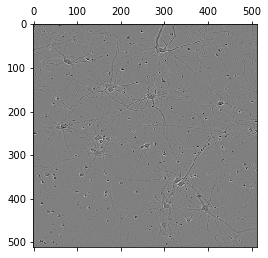

Predicted Mask: 3912a0bede5b - Loss: 0.980


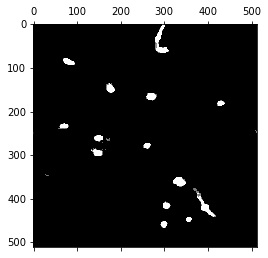

Ground Truth Mask: 3912a0bede5b


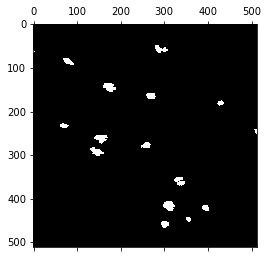

-----------------------------------------


Image: ebaa75979438


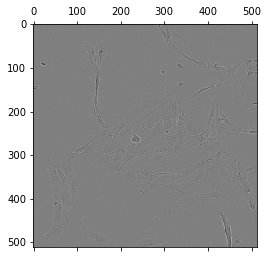

Predicted Mask: ebaa75979438 - Loss: 1.082


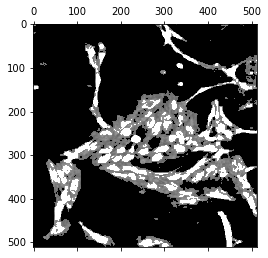

Ground Truth Mask: ebaa75979438


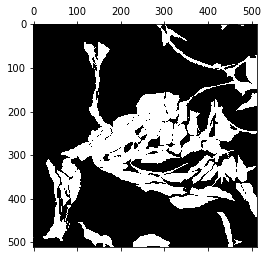

-----------------------------------------


Image: 71d6e508abdc


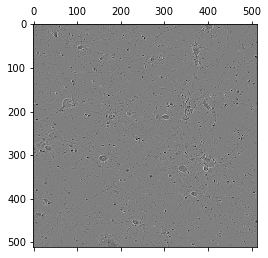

Predicted Mask: 71d6e508abdc - Loss: 0.985


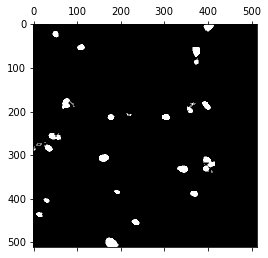

Ground Truth Mask: 71d6e508abdc


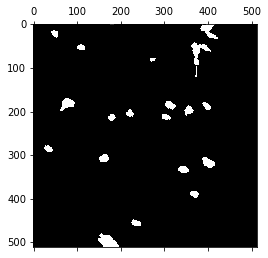

-----------------------------------------



In [19]:
def training(model, dataset, learning_rate, epochs, batch_size=1, num_workers=1, device='cuda'):
    # Pass the dataset to a DataLoader
    cell_dl = DataLoader(cell_data, batch_size=batch_size, drop_last=True, shuffle=True)
    num_batches = len(cell_dl)
    # Init loss and optimizer
    criterion = MixedLoss(10.0, 2.0)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training Loop
    epoch_bar = trange(epochs, desc=f'Epoch: {0}/{epochs} - Progress')
    for epoch in epoch_bar:
        running_loss = 0.0
        optimizer.zero_grad()
        load_batch = tqdm(cell_dl, desc=f'Batch: {0}/{num_batches} - Progress', leave=False)
        for i, batch in enumerate(load_batch):
            # Load and process img and mask
            img_id, images, masks = batch
            masks = torch.permute(masks, (0, 3, 2, 1)).to(device)
            images = torch.permute(images, (0, 3, 2, 1)).to(device)
            # init output holder
            output = torch.zeros(images.shape).to(device)
            
            # Forward Pass
            with torch.cuda.amp.autocast():
                output[:][0:2] = model(images)[0][0] # Cast Height and Width dims to all 3 output_channels
                loss = criterion(output, masks)
            load_batch.set_description(f'Batch: {i}/{num_batches} - Loss: {loss.item():.3f} - Progress')
            
            # Backward Pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
        epoch_bar.set_description(f'Epoch: {epoch}/{epochs} - Epoch-Loss: {(running_loss / num_batches):.3f} - Progress')
        epoch_bar.refresh()
    # Save model state dict for loading later
    # Uncomment to save
    #torch.save(model.state_dict(), f'{DATA_PATH}/model/model.pth')
    torch.cuda.empty_cache()
    return model


def evaluate(model, dataset, device):
    # Init loss and test dataloader
    criterion = MixedLoss(10.0, 2.0)
    test_dl = DataLoader(dataset=dataset, batch_size=1, drop_last=True, shuffle=True)
    eval_bar = tqdm(test_dl, desc=f'Eval: {0}/{len(cell_dl)} - Progress')
    running_loss = 0.0
    num_batches = float(len(test_dl))
    
    # Loop over testing dataset
    for i, batch in enumerate(eval_bar):
        img_id, images, masks = batch
        masks = torch.permute(masks, (0, 3, 2, 1)).to(device)
        images = torch.permute(images, (0, 3, 2, 1)).to(device)
        output = torch.zeros(images.shape).to(device)
        # Forward pass
        with torch.no_grad():
            output[:][0:2] = model(images)[0][0]
            loss = criterion(output, masks)
            running_loss += loss.item()
        eval_bar.set_description(f'Eval: {i}/{len(cell_dl)} - Loss: {loss.item():.3f} - Progress')
        eval_bar.refresh()
    return running_loss / num_batches


def show_predictions(model, dataset, device):
    # Load data
    test_dl = DataLoader(dataset=dataset, batch_size=1, drop_last=True, shuffle=True)
    loaded = iter(test_dl)
    criterion = MixedLoss(10.0, 2.0)
    counter = 0
    # Plot loop
    print('\nPredictions')
    print('-----------------------------------------\n')
    for batch in loaded:
        # Prep batch
        img_id, image, mask = batch
        mask = torch.permute(mask, (0, 3, 2, 1)).to(device)
        image = torch.permute(image, (0, 3, 2, 1)).to(device)
        output = torch.zeros(image.shape).to(device)
        loss = 0.0
        # Forward pass
        with torch.no_grad():
            output[:][0:2] = model(image)[0][0]
            loss += criterion(output, mask).item()
        # Threshold output
        output = torch.sigmoid(output)
        output[output > 0.6] = 1.0
        output[output < 0.4] = 0.0
        # Unpermute inputs/outputs and plot
        image = torch.permute(image, (0, 2, 3, 1))
        mask = torch.permute(mask, (0, 2, 3, 1))
        output = torch.permute(output, (0, 2, 3, 1))
        print(f'\nImage: {img_id[0]}')
        plt.matshow(image[0].to('cpu').numpy())
        plt.show()
        print(f'Predicted Mask: {img_id[0]} - Loss: {loss:.3f}')
        plt.matshow(output[0].to('cpu').numpy())
        plt.show()
        print(f'Ground Truth Mask: {img_id[0]}')
        plt.matshow(mask[0].to('cpu').numpy())
        plt.show()
        print('-----------------------------------------\n')
        # Probably a better way to do this but subplot is weird with matshow and I don't like imshow
        counter += 1
        if counter == 3:
            break


def main():
    # Hyperparameters
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    lr = 3e-4
    epochs = 3
    transforms = A.Compose([A.Resize(512, 512),
                       A.Normalize(mean=(0.0, 0.0, 0.0),
                                    std=(1.0, 1.0, 1.0),
                                    max_pixel_value=255.0,
                                    p=1.0),
                       A.HorizontalFlip(p=0.5),
                       A.VerticalFlip(p=0.5),
                       A.Rotate(limit=35, p=1.0)])
    
    # Load the training and testing data
    cell_data_train = CellDataset(data=train, train=True, transform=transforms)
    cell_data_test = CellDataset(data=train, train=False, transform=transforms)
    
    # Construct Model
    model = UNet(3, 1).to(device)
    # Train/load the model
    #model = training(model, cell_data_train, lr, epochs, batch_size=1, device=device)
    model.load_state_dict(torch.load(f'{DATA_PATH}/model/model.pth'))
    
    test_loss = evaluate(model, cell_data_test, device)
    print(f'Test Loss: {test_loss:.3f} - Test Size: {len(cell_data_test)} samples')
    show_predictions(model, cell_data_test, device)


if __name__ == "__main__":
    main()


Predictions
-----------------------------------------


Image: 559904fcd4a2


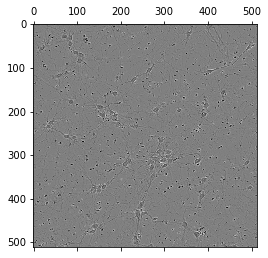

Predicted Mask: 559904fcd4a2 - Loss: 4.314


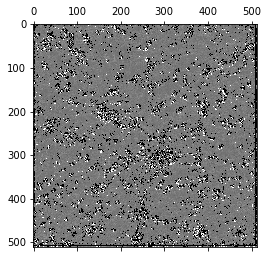

Ground Truth Mask: 559904fcd4a2


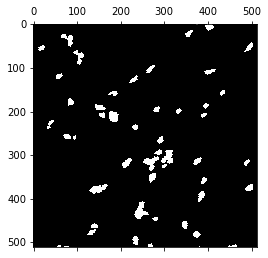

-----------------------------------------


Image: 6b165d790e33


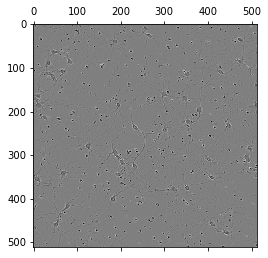

Predicted Mask: 6b165d790e33 - Loss: 4.962


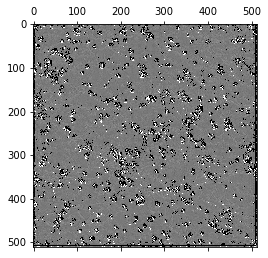

Ground Truth Mask: 6b165d790e33


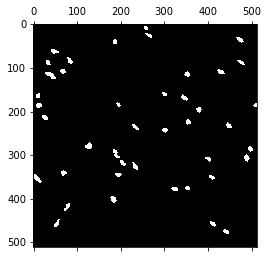

-----------------------------------------


Image: 04cd81dfb245


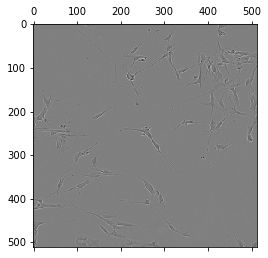

Predicted Mask: 04cd81dfb245 - Loss: 3.641


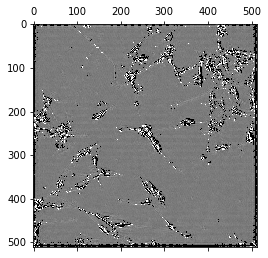

Ground Truth Mask: 04cd81dfb245


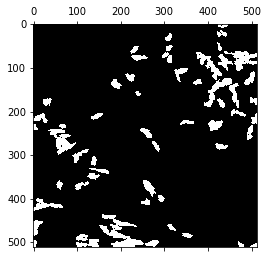

-----------------------------------------



In [21]:
# Loading untrained model for comparison
device = torch.device('cuda')
cell_data_test = CellDataset(data=train, train=False, transform=transforms)
model = UNet(3,1).to(device)
show_predictions(model, cell_data_test, device)